In [1045]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import plotly.express as px


## Open Data

In [1046]:
dt = pd.read_csv("data/train.csv")
dt.shape


/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



(637774, 9)

## Clean Data

In [1053]:
def count_consecutive_zeros(s):
    v = np.diff(np.r_[0, s.values==0, 0])
    s = pd.value_counts(np.where(v == -1)[0] - np.where(v == 1)[0])
    s.index.name = "num_consecutive_zeros"
    s.name = "count"
    return s

In [1075]:
#Make a variable that counts until the next open day (normal Sunday should not count)
dt.Open.value_counts()
#dt_eng['Sales_MA7'] = 
#dt["Closed"] = (dt.Open-1) * -1
#dt["New"] = dt.groupby('Store')['Closed'].cumsum()


dt["firstStore"] = dt.groupby('Store')['Open'].first()
dt.firstStore.replace({0: 1}, inplace=True)
dt.firstStore.fillna(0, inplace=True)
shop2 = (dt.loc[:, "Store"]==2) #| (dt.loc[:, "Store"]==3) 
px.scatter(dt[shop2], x="Date", y="firstStore",  color='Store')
dt.loc[shop2, ["Date", "firstStore"]]

,Date,firstStore
367,2013-01-01,1.0
1481,2013-01-02,0.0
2595,2013-01-03,0.0
3712,2013-01-04,0.0
4825,2013-01-05,0.0
...,...,...
633414,2014-07-27,0.0
634349,2014-07-28,0.0
635284,2014-07-29,0.0
636219,2014-07-30,0.0


In [875]:
# Clear Missing Values for the target variable
dt.loc[:, "Sales"].isnull().sum()

19027

In [876]:
dt = dt.dropna( how='any', subset=['Sales'])
dt = dt.drop("Customers", axis=1)

In [877]:
sales_zeros=(dt["Sales"] == 0)
dt = dt.loc[~sales_zeros, :]

In [878]:
dt.isnull().sum()

Date                 0
Store            15580
DayOfWeek        15299
Sales                0
Open             15455
Promo            15439
StateHoliday     15560
SchoolHoliday    15547
dtype: int64

In [879]:
#Baseline
dt.loc[:, "Sales"].mean()

6836.975867325853

In [880]:
dt

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
27,2013-01-01,353.0,2.0,3139.0,1.0,0.0,a,1.0
115,2013-01-01,335.0,2.0,2401.0,1.0,0.0,a,1.0
147,2013-01-01,512.0,2.0,2646.0,1.0,0.0,a,1.0
162,2013-01-01,494.0,2.0,3113.0,1.0,0.0,a,1.0
199,2013-01-01,530.0,2.0,2907.0,1.0,0.0,a,1.0
...,...,...,...,...,...,...,...,...
637769,2014-07-31,752.0,4.0,7259.0,1.0,1.0,0,1.0
637770,2014-07-31,753.0,NaN,9938.0,1.0,1.0,0,1.0
637771,2014-07-31,754.0,4.0,10564.0,1.0,1.0,0,NaN
637772,2014-07-31,755.0,4.0,12302.0,1.0,1.0,0,1.0


### Join with Stores

In [881]:
data_store = pd.read_csv("data/store.csv")
data_store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [882]:
data_store.shape

(1115, 10)

In [883]:
dt.shape

(512956, 8)

In [884]:
dt_full = dt.merge(data_store, left_on='Store', right_on='Store', how="left")

## Exploratory Analysis

In [885]:
dt_full.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [886]:
dt_full.Promo.value_counts()

0.0    281859
1.0    215658
Name: Promo, dtype: int64

In [887]:
dt_full.DayOfWeek.value_counts()

6.0    85139
2.0    84995
3.0    82859
5.0    82472
1.0    80809
4.0    79312
7.0     2071
Name: DayOfWeek, dtype: int64

In [888]:
dt_full.Open.value_counts()

1.0    497501
Name: Open, dtype: int64

In [889]:
dt_full.StateHoliday.value_counts()

0      444136
0.0     52717
a         415
b          93
c          35
Name: StateHoliday, dtype: int64

In [890]:
dt_full.SchoolHoliday.value_counts()

0.0    404398
1.0     93011
Name: SchoolHoliday, dtype: int64

In [891]:
dt_full.Store.value_counts()

733.0     551
335.0     547
85.0      546
769.0     545
494.0     544
         ... 
348.0     400
972.0     383
1081.0    373
349.0     372
103.0     304
Name: Store, Length: 1115, dtype: int64

In [892]:
dt_full.StoreType.value_counts()

a    268425
d    154104
c     65902
b      8945
Name: StoreType, dtype: int64

In [893]:
#get rid of missing store
dt_full = dt_full.dropna( how='any', subset=["Store"])

dt_full.loc[:, "Store"] = dt_full.loc[:, "Store"].astype(int)

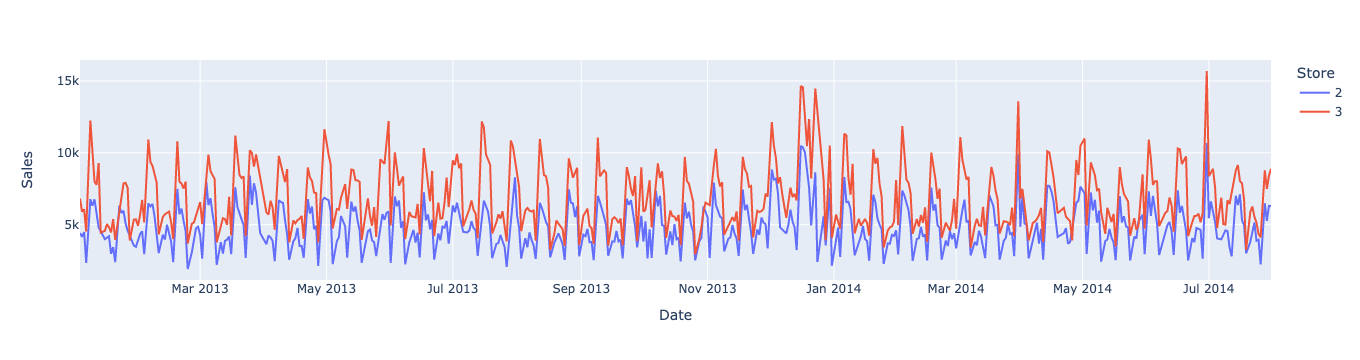

In [894]:

#dt_full.loc[:, "Monday"] = dt_full.loc[:, "DayOfWeek"]==1
shop2 = (dt_full.loc[:, "Store"]==2) | (dt_full.loc[:, "Store"]==3) 
#shop2 = (dt_full.loc[:, "Store"]==3) 

px.line(dt_full[shop2], x="Date", y="Sales",  color='Store')
#px. add_line(dt_full[shop2], x="Date", y="Sales")
#, animation_frame="year", ,size="pop", color="continent", hover_name="country",log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90]

# Feature Engineering

In [972]:
#make one-hot-encoding for the StateHoliday variable
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
dt_eng = dt_full
dt_eng.loc[: , "PublicHoliday"] = dt_full.loc[:, "StateHoliday"]=="a" 
dt_eng.loc[: , "Easter"] = dt_full.loc[:, "StateHoliday"]=="b" 
dt_eng.loc[: , "Christmas"] = dt_full.loc[:, "StateHoliday"]=="c" 
#dt_eng = dt.drop("StateHoliday", axis=1)


In [973]:
dt_full.StateHoliday.isnull().sum()

15031

In [974]:
dt_eng.PublicHoliday.isnull().sum()

0

In [975]:
#StoreType
#try either target encoding or one-hot encoding
dummies = pd.get_dummies(dt_full.loc[:, "StoreType"], prefix="storetype", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)



In [976]:
dt_eng = dt_eng.join(dt_eng.groupby("StoreType")["Sales"].mean(), how="left", on="StoreType", rsuffix="_avg_storetype")

In [977]:
dt_eng = dt_eng.join(dt_eng.groupby("Store")["Sales"].mean(), how="left", on="Store", rsuffix="_avg_store")
dt_eng = dt_eng.join(dt_eng.groupby("Store")["Sales"].median(), how="left", on="Store", rsuffix="_median_store")

In [978]:
#Assortment
#could be ordinal encoding
#dt_full.loc[dt_full['Assortment']=="a", "Sales"]
dt_eng.groupby("Assortment").mean()['Sales']
dummies = pd.get_dummies(dt_eng.loc[:, "Assortment"], prefix="assort", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)


In [979]:
dt_eng.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'PublicHoliday',
       'Easter', 'Christmas', 'storetype_a', 'storetype_b', 'storetype_c',
       'storetype_d', 'Sales_avg_storetype', 'Sales_avg_store',
       'Sales_median_store', 'assort_a', 'assort_b', 'assort_c'],
      dtype='object')

In [980]:
dt_eng.loc[:, ["Store", "CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]]

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
0,353,900.0,NaN,NaN
1,335,90.0,NaN,NaN
2,512,590.0,NaN,NaN
3,494,1260.0,6.0,2011.0
4,530,18160.0,NaN,NaN
...,...,...,...,...
512951,752,970.0,3.0,2013.0
512952,753,540.0,11.0,2012.0
512953,754,380.0,5.0,2008.0
512954,755,13130.0,12.0,2003.0


In [981]:
dt_eng.loc[dt_eng["Store"]==2, ["Store", "Sales", "Date", "CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]].head(10)

,Store,Sales,Date,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
374,2,4422.0,2013-01-02,570.0,11.0,2007.0
1456,2,4159.0,2013-01-03,570.0,11.0,2007.0
2536,2,4484.0,2013-01-04,570.0,11.0,2007.0
3610,2,2342.0,2013-01-05,570.0,11.0,2007.0
4698,2,6775.0,2013-01-07,570.0,11.0,2007.0
5773,2,6318.0,2013-01-08,570.0,11.0,2007.0
6847,2,6763.0,2013-01-09,570.0,11.0,2007.0
7911,2,5618.0,2013-01-10,570.0,11.0,2007.0
8987,2,4810.0,2013-01-11,570.0,11.0,2007.0
11153,2,3995.0,2013-01-14,570.0,11.0,2007.0


In [982]:
#CompetitionDistance could be metric or maybe squared?


In [983]:
#Promo2 how is this working?
dt_eng.loc[:, ["Store", "Promo2", "Promo2SinceWeek", "Promo2SinceYear"]]

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear
0,353,1.0,14.0,2013.0
1,335,1.0,31.0,2013.0
2,512,1.0,5.0,2013.0
3,494,0.0,NaN,NaN
4,530,0.0,NaN,NaN
...,...,...,...,...
512951,752,1.0,31.0,2013.0
512952,753,1.0,35.0,2010.0
512953,754,1.0,10.0,2014.0
512954,755,0.0,NaN,NaN


In [984]:
dt_eng.loc[dt_eng["Store"]==2, ["Store", "Sales", "Date", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]].head(10)

,Store,Sales,Date,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
374,2,4422.0,2013-01-02,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
1456,2,4159.0,2013-01-03,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
2536,2,4484.0,2013-01-04,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
3610,2,2342.0,2013-01-05,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
4698,2,6775.0,2013-01-07,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
5773,2,6318.0,2013-01-08,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
6847,2,6763.0,2013-01-09,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
7911,2,5618.0,2013-01-10,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
8987,2,4810.0,2013-01-11,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
11153,2,3995.0,2013-01-14,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [985]:
#CompetitionOpenSince[Month/Year]
#should be interacted with competitionDistance


In [986]:
dt_eng.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'PublicHoliday',
       'Easter', 'Christmas', 'storetype_a', 'storetype_b', 'storetype_c',
       'storetype_d', 'Sales_avg_storetype', 'Sales_avg_store',
       'Sales_median_store', 'assort_a', 'assort_b', 'assort_c'],
      dtype='object')

### put in interactions

In [987]:
#do different store types react differently to christmas?
#plt.bar(dt_eng["DayOfWeek"], height=dt_eng["Sales"])
#plt.show()

In [988]:
#import plotly.express as px
#fig = px.bar(dt_eng, x='year', y='pop')
#fig.show()

In [989]:
#Storetypes reacting to Christmas
dt_eng.loc[:, "SAXmas"] = dt_eng.storetype_a * dt_eng.Christmas
dt_eng.loc[:, "SBXmas"] = dt_eng.storetype_b * dt_eng.Christmas
dt_eng.loc[:, "SCXmas"] = dt_eng.storetype_c * dt_eng.Christmas
dt_eng.loc[:, "SDXmas"] = dt_eng.storetype_d * dt_eng.Christmas

dt_eng.loc[:, "logDistance"] = np.log(dt_eng.loc[:, "CompetitionDistance"])

### time series stuff

In [990]:
#MOVING 7 day average (but i think we will not have this fpr the prediction so i dont use it)
#dt_eng['Sales_MA7'] = 
dt_eng = dt_eng.dropna( how='any', subset=["Store"])
#Moving Average 7 day
dt_eng['Sales_MA7'] = dt_eng.groupby('Store')['Sales'].transform(lambda x: x.rolling(7, 1).mean())


In [991]:
store23 = (dt_eng.loc[:, "Store"]==1 )
#check = dt_eng.loc[store23, :]
#dt_eng["lag14"] = dt_eng.groupby("Store")["Sales"].shift(14)
#dt_eng[store23].head(22)

In [992]:
#i should do smth like "14 days ago" aka AR14
#print(dt_eng.shape)
#dt_eng = pd.concat([dt_eng, dt_eng.loc[:, "Sales"].shift(14)], axis=1)
#print(dt_eng.shape)

In [993]:
##Add Monthly Fixed Effects
dt_eng['day'] = pd.DatetimeIndex(dt_eng['Date']).day
dt_eng['month'] = pd.DatetimeIndex(dt_eng['Date']).month
dt_eng['week'] = pd.DatetimeIndex(dt_eng['Date']).week
dt_eng['year'] = pd.DatetimeIndex(dt_eng['Date']).year

<ipython-input-993-907aadee8390>:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [994]:
#Beginning of the month craze
dt_eng["monthstart"] = (dt_eng.day>=30) | ( dt_eng.day<=3)

In [995]:
#i want to have a promo counter. i assume that a promo is effective for 1 month (30 days). If a new Promo2 starts, it is set to 30 and then decreases daily
#if the promo is 
store23 = (dt_eng.loc[:, "Store"]==30)

dt_eng["prstart"] = (dt_eng.Promo2SinceWeek <= dt_eng.week) & (dt_eng.Promo2SinceYear <= dt_eng.year)

dt_eng.loc[store23, ["Date", "Promo2",  "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval" , "week", "year", "prstart"]].tail(60)


#dt_eng.groupby("Store")["Promo2"].mean().head(60)

,Date,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week,year,prstart
451442,2014-05-19,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",21,2014,True
452518,2014-05-20,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",21,2014,True
453598,2014-05-21,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",21,2014,True
454684,2014-05-22,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",21,2014,True
455763,2014-05-23,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",21,2014,True
456835,2014-05-24,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",21,2014,True
457950,2014-05-26,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",22,2014,True
460107,2014-05-28,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",22,2014,True
461212,2014-05-30,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",22,2014,True
462297,2014-05-31,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",22,2014,True


## Final Feature selection

In [1004]:
features = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'prstart', 'PublicHoliday', 'Easter', 'Christmas', 
                    'storetype_a', 'storetype_b', 'storetype_c', 'storetype_d', 'assort_a', 'assort_b', 'assort_c']
features = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'logDistance', 'Promo2', 'PublicHoliday', 'Easter', 'Christmas', 
                    'Sales_avg_store', 'storetype_a', 'storetype_b', 'storetype_c', 'storetype_d', 'assort_a', 'assort_b', 'assort_c', "month", "monthstart"] 
          # 'SAXmas','SBXmas','SCXmas','SDXmas'  "Sales_MA7",

In [1005]:
dt_eng_nomissing = dt_eng.dropna( how='any', subset=["StateHoliday", "Assortment"])

dt_eng_nomissing = dt_eng_nomissing.dropna( how='any', subset=features)


In [1006]:
X = dt_eng_nomissing.loc[:, features ]
y = dt_eng_nomissing.loc[:, 'Sales']

In [1007]:
X.isnull().sum()

DayOfWeek              0
Open                   0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
logDistance            0
Promo2                 0
PublicHoliday          0
Easter                 0
Christmas              0
Sales_avg_store        0
storetype_a            0
storetype_b            0
storetype_c            0
storetype_d            0
assort_a               0
assort_b               0
assort_c               0
month                  0
monthstart             0
day                    0
dtype: int64

In [1008]:
#import plotly.express as px
#fig = px.scatter(X.loc[:, "DayOfWeek"], y)
#fig.show()

## Split Data in Test/Train

In [1009]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=None)

## Modelling

### Baseline

In [1010]:
def rmspe(preds, actuals):
    #preds = preds.reshape(-1)
    #actuals = actuals.reshape(-1)
    #assert preds.shape == actuals.shape
    return np.sqrt(np.mean(np.square((actuals-preds) / actuals))) * 100

In [1011]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
#pred = lr.predict(X_test)
#actual = y_test
rmspe(lr.predict(X_test), y_test)

24.968832546052333

### Random Forest

In [971]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=40, random_state=42, verbose=1, n_jobs=-1, warm_start=False)
rf.fit(X_train,y_train)

print(f'The RSME is {rmspe(rf.predict(X_test), y_test)}')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s


The RSME is 16.904622214716653


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


In [940]:
X_test.columns

Index(['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'logDistance', 'Promo2', 'PublicHoliday', 'Easter', 'Christmas',
       'Sales_avg_store', 'storetype_a', 'storetype_b', 'storetype_c',
       'storetype_d', 'assort_a', 'assort_b', 'assort_c', 'month'],
      dtype='object')

In [941]:

error_analysis = X_train
error_analysis.loc[:, "error"] = y_train-rf.predict(X_train)
error_analysis

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.3s finished
/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,logDistance,Promo2,PublicHoliday,Easter,Christmas,Sales_avg_store,storetype_a,storetype_b,storetype_c,storetype_d,assort_a,assort_b,assort_c,month,error
152075,5.0,1.0,1.0,0.0,2000.0,7.600902,1.0,False,False,False,6893.852018,0,0,0,1,0,0,1,6,-1866.019667
357048,1.0,1.0,1.0,0.0,1090.0,6.993933,1.0,False,False,False,7390.901345,0,0,0,1,0,0,1,2,740.785099
237155,5.0,1.0,0.0,0.0,16210.0,9.693384,0.0,False,False,False,5549.625551,1,0,0,0,0,0,1,9,85.430833
217591,5.0,1.0,1.0,0.0,1530.0,7.333023,0.0,False,False,False,17850.921225,1,0,0,0,0,0,1,8,631.541000
6797,3.0,1.0,1.0,0.0,270.0,5.598422,1.0,False,False,False,6526.192394,1,0,0,0,1,0,0,1,1198.667500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312497,5.0,1.0,0.0,0.0,4880.0,8.492900,1.0,False,False,False,8496.206972,0,0,0,1,0,0,1,12,-154.945000
440913,3.0,1.0,1.0,0.0,18050.0,9.800901,1.0,False,False,False,6111.991071,1,0,0,0,0,0,1,5,12.834310
159212,5.0,1.0,0.0,0.0,340.0,5.828946,1.0,False,False,False,6630.553531,1,0,0,0,1,0,0,6,81.129167
177208,4.0,1.0,1.0,0.0,250.0,5.521461,0.0,False,False,False,4418.346578,1,0,0,0,1,0,0,7,-334.262381


In [942]:
error_analysis = pd.merge(error_analysis,dt_eng_nomissing.loc[:, ["Store", "Date"]] , how='left', left_index=True, right_index=True)


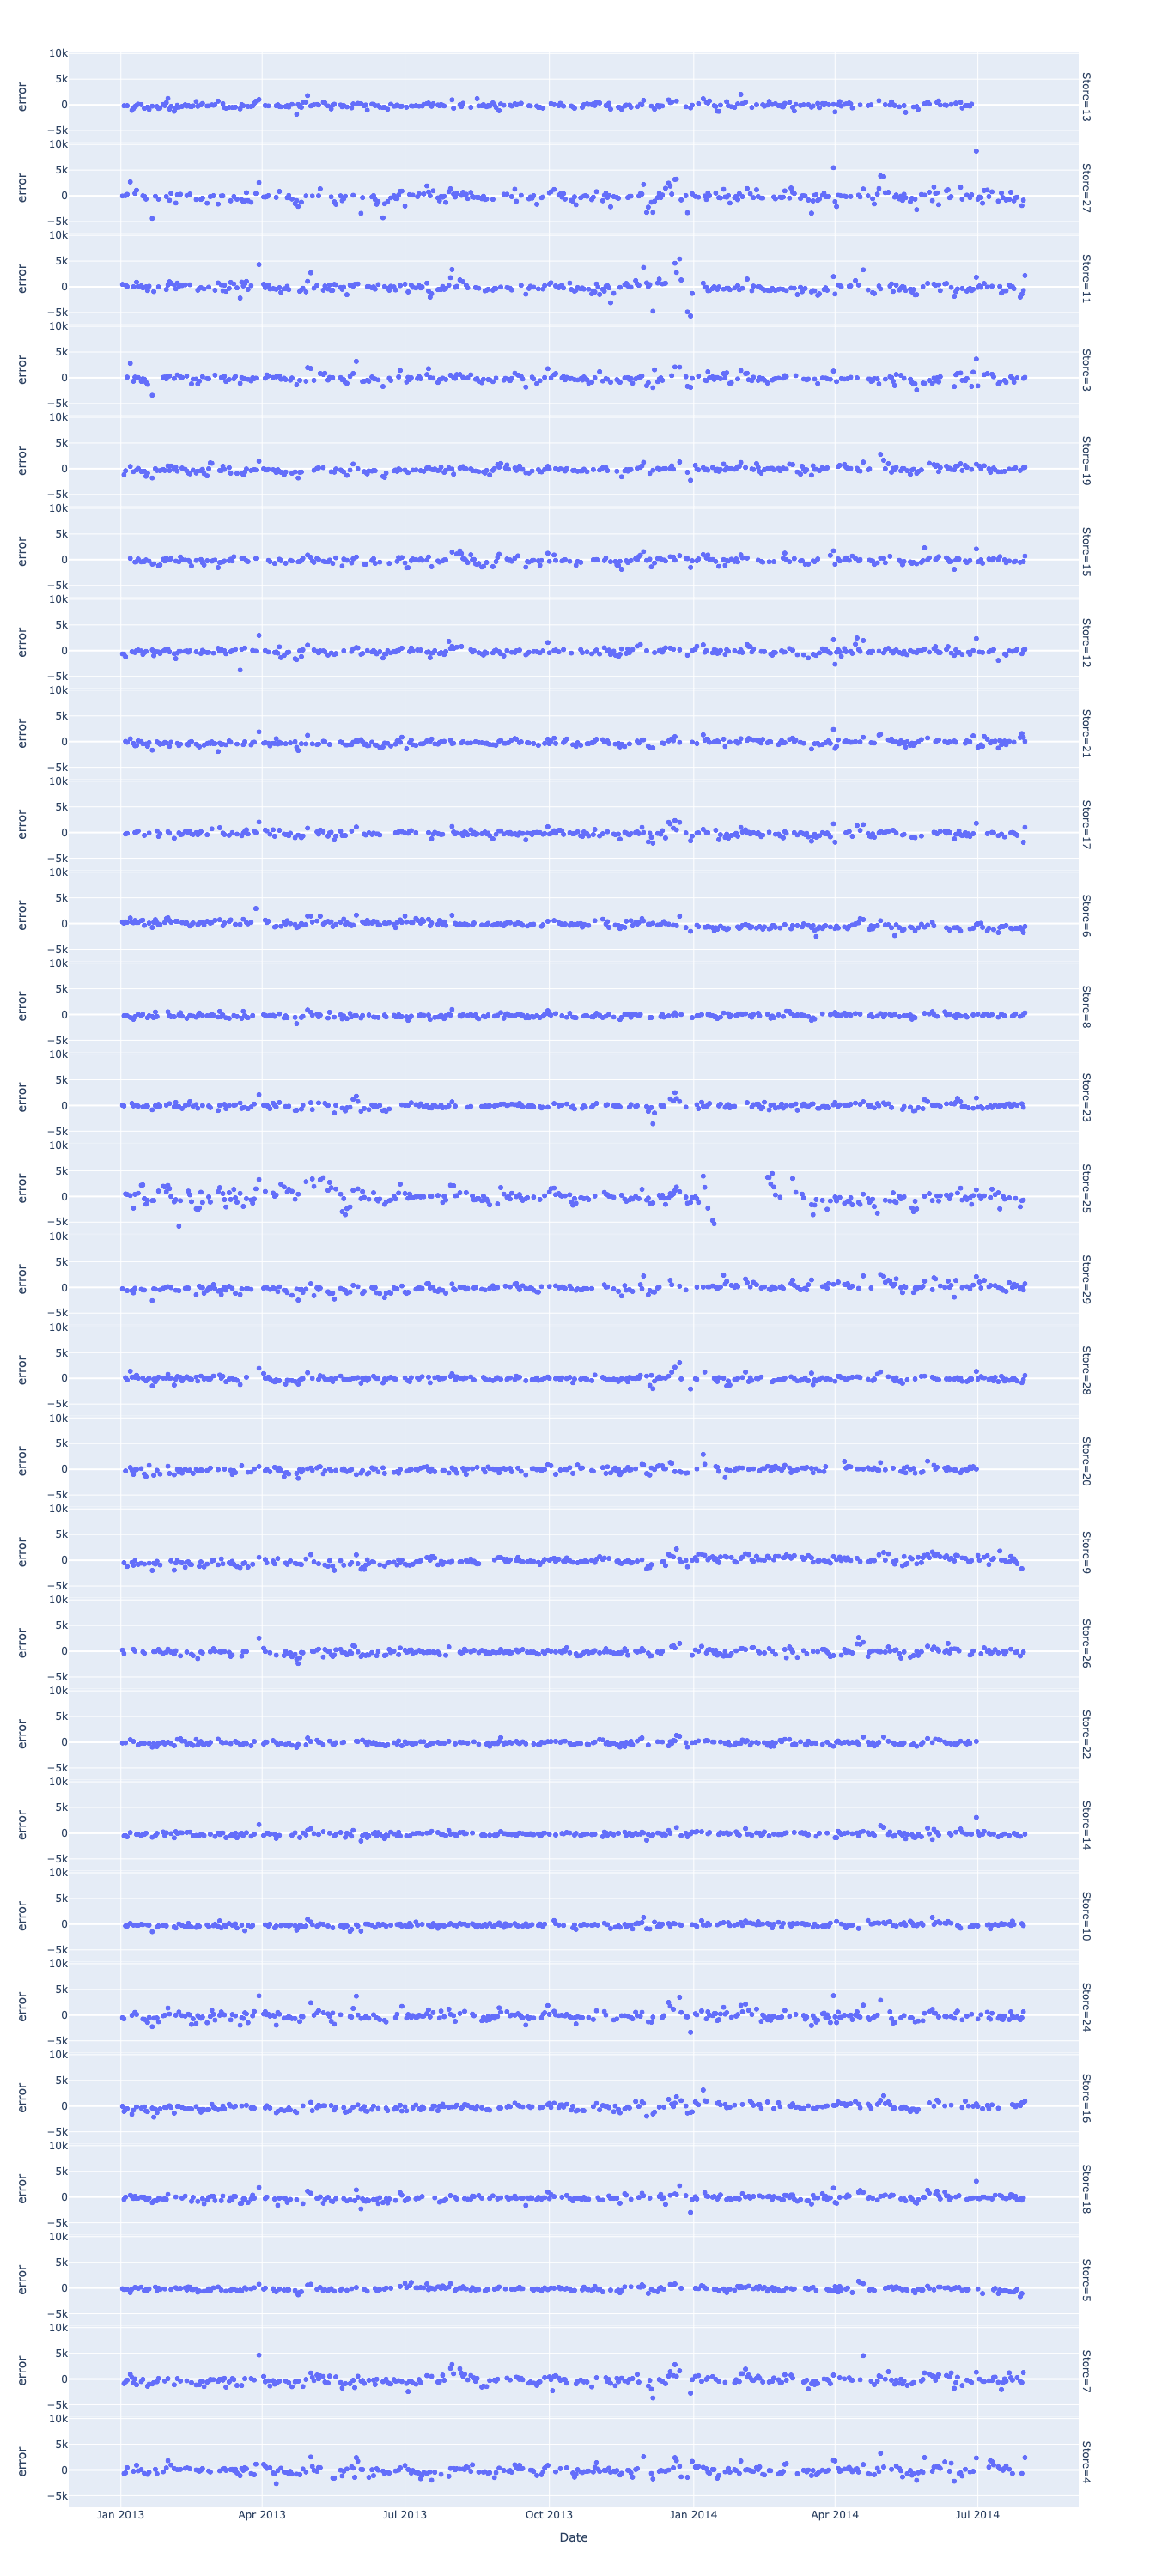

In [943]:
#error_analysis = error_analysis.reset_index()
shop2 = (error_analysis.loc[:, "Store"]>2) & (error_analysis.loc[:, "Store"]<30) 
error_analysis.sort_values("Date")
px.scatter(error_analysis[shop2], x="Date", y="error",  facet_row='Store', height=3000, facet_row_spacing=0.0001)

### XGBoost

In [369]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(max_depth=10,learning_rate=0.1,n_estimators=100,n_jobs=-1)
xgbr.fit(X_train,y_train)
rmspe( xgbr.predict(X_test), y_test)

14.73852279379334

SyntaxError: invalid syntax (<ipython-input-71-a0db21d94510>, line 1)